In [1]:
# 1. GitHub에서 코드를 클론
!git clone https://github.com/harvardnlp/annotated-transformer.git
%cd annotated-transformer

# 2. requirements.txt 파일이 있는 위치로 이동한 후 설치
!pip install -r requirements.txt


Cloning into 'annotated-transformer'...
remote: Enumerating objects: 978, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 978 (delta 175), reused 172 (delta 172), pack-reused 672 (from 1)
Receiving objects: 100% (978/978), 18.03 MiB | 7.81 MiB/s, done.
Resolving deltas: 100% (442/442), done.
/content/annotated-transformer
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 50.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement torch==1.11.0+cu113 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.wit

In [2]:
# Uncomment for colab
#
!pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm



ERROR: Could not find a version that satisfies the requirement torchtext==0.12 (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0)
ERROR: No matching distribution found for torchtext==0.12
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/usr/local/lib/python3.11/dist-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/usr/local/lib/python3.11/dist-packages/spacy/errors.py", line 3, in <module>
    from .compat import Literal
  File "/usr/local/lib/python3.11/dist-packages/spacy/compat.py", line 4, in <module>
    from thinc.util import copy_array
  File "/usr/local/lib/python3.11/dist-packages/thinc/__init__.py", line 5, in <module>
    from .config import registry
  File "/usr

In [1]:
# Some convenience helper functions used throughout the notebook

import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torch.utils.data import DataLoader
import spacy
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True
def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

## Model Architecture

In [2]:
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generater):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.src_embed=src_embed
    self.tgt_embed=tgt_embed
    self.generater=generater

  def forward(self, src, tgt, src_mask,tgt_mask):
    return self.decode(self.encode(src, src_mask),src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask) # memory는 인코더의 출력 전체(시퀀스별 임베딩 벡터 집합)



In [3]:
class Generator(nn.Module):
  "Define standard linear + softmax generation step."
  def __init__(self, d_model, vocab):
    super().__init__()
    self.proj=nn.Linear(d_model, vocab)

  def forward(self, x):
    return log_softmax(self.proj(x), dim=-1)


## Encoder

In [4]:
def clones(module, N):
  "produce N identical layers"
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


In [5]:
class LayerNorm(nn.Module):
  "Construct a layernorm module (see citation for details)"
  def __init__(self, features, eps=1e-6):
    super().__init__()
    self.a_2=nn.Parameter(torch.ones(features)) # 파라미터로써 등록 안하면 학습 끊기니까 LayerNorm레이어의 결과를 학습가능하도록 함.
    self.b_2=nn.Parameter(torch.zeros(features))
    self.eps=eps

  def forward(self, x):
    mean=x.mean(-1, keepdim=True) # 마지막 차원 = 열 기준 = 가로로 더하고 평균 = 이후 열의 모습만 유지됨(n*1)
    std=x.std(-1, keepdim=True)
    return self.a_2*(x-mean)/(std+self.eps) + self.b_2 # 아핀 변환, b_2 (시프팅): 스케일링된 데이터의 위치를 조절
    # a_2 (스케일링): 표준화된 데이터의 진폭(크기)을 조절

In [6]:
class Encoder(nn.Module):
  "인코더는 (N)6개의 레이어로 이루어짐"

  def __init__(self, layer, N):
    super().__init__()
    self.layers=clones(layer,N)
    self.norm=LayerNorm(layer.size)

  def forward(self, x, mask):
    "pass the input through each layer in turn"
    for layer in self.layers:
      x=self.norm(layer(x))
    return x


In [7]:
class SublayerConnection(nn.Module):
  """
  레이어 정규화 후, 레지듀얼 커넥션
  """

  def __init__(self, size, dropout):
    super().__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer): # sublayer는 함수
    return x+self.dropout(sublayer(self.norm(x))) # 정규화되지 않은 원래 입력 x 그대로 사용하고, 정규화는 sublayer에만 적용

In [8]:
class EncoderLayer(nn.Module):
  "인코더는 셀프어텐션과 FFN으로 만들어진다"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super().__init__()
    self.self_attn=self_attn
    self.feed_forward=feed_forward
    self.sublayer=clones(SublayerConnection(size, dropout), 2) # size: 입력 벡터 차원, d_model
    self.size = size

  def forward(self, x, mask): # 마스크는 패딩 무시용
    "Follow Figure 1 (left) for connections."
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # nn.Module을 상속하면 __call__이 forward()를 자동 호출
    return self.sublayer[1](x, self.feed_forward)

## Decoder

In [9]:
class Decoder(nn.Module):
  "마스킹을 적용하며 N개의 일반적인 레이어"

  def __init__(self, layer, N):
    super().__init__()
    self.layers=clones(layer,N)
    self.norm=LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x=layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)



In [10]:
class DecoderLayer(nn.Module):
  "디코더는 셀프어텐션, 소스어텐션, FFN로 이루어짐"

  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super().__init__()
    self.size=size
    self.self_attn=self_attn
    self.src_attn=src_attn
    self.feed_forward = feed_forward
    self.sublayer=clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    m=memory
    x=self.sublayer[0](x, lambda x: self.self_attn(x,x,x,tgt_mask))
    x=self.sublayer[1](x, lambda x: self.src_attn(x,x,x,src_mask))
    return self.sublayer[2](x, self.feed_forward)



In [11]:
# 디코더가 이후 출력값을 미리 보지 못하게 하기 위함
def subsequent_mask(size):
  attn_shape=(1, size, size)
  subsequent_mask=torch.triu(torch.ones(attn_shape),diagonal=1).type( # upper triangle
      torch.uint8
  )
  return subsequent_mask == 0 # 불리언 마스크 생성: 0인 위치는 True, 1인 위치는 False

## Attention
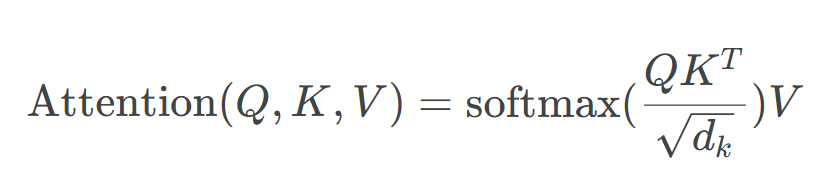

In [12]:
def attention(query, key, value, mask=None, dropout=None):
  "Scaled Dot Product Attention"
  d_k=query.size(-1) # 512
  scores=torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k) # 뒤에서 두 번째(-2)와 마지막(-1) 차원 change
  if mask is not None:
    scores=scores.masked_fill(mask==0, -1e9)
  p_attn= scores.softmax(dim=-1)
  if dropout is not None:
    p_attn=dropout(p_attn) # 특정 어텐션 가중치에 과도하게 의존하는 것을 방지하여 일반화 성능 높임
  return torch.matmul(p_attn, value), p_attn # 컨텍스트 벡터 리턴

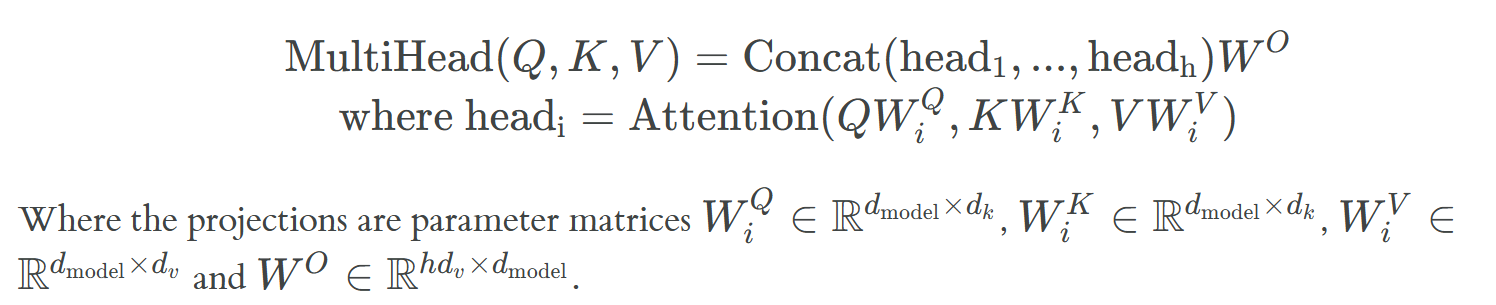

In [13]:
class MultiheadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    # 모델 사이즈(512) 와 헤드 갯수를 받는다
    super().__init__()
    assert d_model % h==0 # d_model이 h로 딱 나누어떨어져야 한다, 각 헤드 64차원, 8개 헤드 = 512 / 512차원의 토큰벡터를 8개의 헤드가 나눠서 관리->concat
    # 각 헤드는 d_model // h 차원을 가짐
    self.d_k=d_model//h
    self.h=h
    self.linears=clones(nn.Linear(d_model, d_model),4) # in_features=d_model, out_features=d_model
    # # Q, K, V, 마지막 output projection을 위한 4개의 Linear layer를 복제하여 저장
    self.attn=None
    self.dropout=nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      mask = mask.unsqueeze(1) # [batch, 1, seq_len, seq_len]로 차원 늘림 (브로드캐스트 위함)
    nbatches=query.size(0)

    # 멀티헤드 어텐션을 위해 쿼리 /키 /밸류를 헤드별로 분할
    # transpose를 통해 head 차원을 앞쪽으로 배치 (attention 연산을 위해)
    query, key, value=[
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2) # -1 -> seq_len :인풋토큰개수 ,batch : 동시에 처리되는 샘플(문장)의 개수
        for lin, x in zip(self.linears, (query,key,value)) # [nbatches, h, seq_len, d_k]
    ]

    # Apply attention on all the projected vectors in batch
    x, self.attn = attention(
        query, key, value, mask=mask, dropout=self.dropout
    )
    # x 차원은 이전과 동일, 쿼리는 seq_len 만큼 있으므로 컨텍스트 벡터도 그만큼 있음
    # "Concat" using a view and ...
    x=(
        x.transpose(1,2)
        .contiguous()
        .view(nbatches, -1, self.h*self.d_k) # 배치, seq_len, 512 (Q는 인풋토큰만큼 문장내에서 연산하기 때문에,)
    )
    """
    텐서를 다양한 방식(특히 .transpose(), .view(), .permute())으로 변형하면,
    메모리 상에서 데이터가 연속적이지 않은(non-contiguous) 상태가 될 수 있습니다.

    .contiguous()를 호출하면,
    메모리 상에서 데이터를 새롭게 복사해서 연속적인(Contiguous) 배열로 만들어
    """
    del query # del query는 더 이상 필요 없는 텐서를 명시적으로 삭제해, 메모리(특히 GPU 메모리) 누수를 방지
    del key
    del value
    return self.linear[-1](x) # apply a final linear.


## Position-wise Feed-Forward Networks
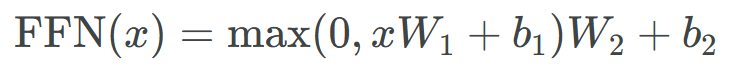

In [14]:
class PositionwiseFeedForward(nn.Module):
  "Implements FFN equation"

  def __init__(self, d_model, d_ff, dropout=0.1): # d_ff= 2048
    super().__init__()
    self.w_1=nn.Linear(d_model, d_ff)
    self.w_2=nn.Linear(d_ff, d_model)
    self.dropout=nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu()))

##Embeddings and Softmax

In [16]:
class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super().__init__()
    # nn.Embedding으로 랜덤 초기화된 임베딩 사용
    self.lut=nn.Embedding(vocab, d_model) # num_embeddings, embedding_dim이고 정수인덱스 입력으로 받아서 임베딩 벡터 출력
    # lut은 룩업테이블처럼 동작한 결과고, [batch, seq_len, d_model]의 임베딩 벡터 나옴
    self.d_model=d_model

  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)
    # 초기에 positional encoding과 임베딩의 스케일이 잘 맞지 않아서 임베딩의 표준편차를 늘리기 위해 d_model 곱함


##Positional Encoding
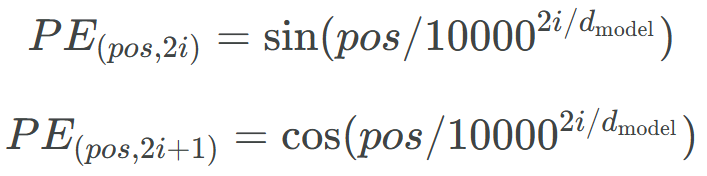

In [18]:
# position은 문장 내 토큰 위치고, i는 토큰 임베딩 벡터의 차원 인덱스
# sin/cos는 서로 다른 주기로 반복되는 함수라 다양한 상대 위치를 표현

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

## Full Model

In [19]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
  c=copy.deepcopy
  attn=MultiheadedAttention(h, d_model)
  ff=PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)

  model=EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(position)), # PositionalEncoding 모듈이 내부적으로 더하는 역할
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
      Generator(d_model, tgt_vocab),
  )

    # 모델을 초기화할 때 가중치(weight) 파라미터를 Xavier(Glorot) 방식으로 초기화(uniform 분포)
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return model